# Clustering - Treinar K-means - Economiza+ MVP

**Objetivo:** Treinar modelo K-means para segmentação de usuários

**Checklist:**
- Normalizar features (StandardScaler)
- Treinar K-means para K=3, 4, 5
- Elbow Curve
- Escolher melhor K
- Salvar modelos

## 1. Imports e Configurações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
# Teste rápido - verificar se sklearn está instalado
import sys
print(f"Python: {sys.version}")
print(f"Caminho: {sys.executable}")

# Testar import básico
try:
    import sklearn
    print(f"✓ scikit-learn {sklearn.__version__} instalado!")
except ImportError as e:
    print(f"✗ Erro: {e}")

Python: 3.12.3 (main, Jun 22 2025, 11:00:19) [GCC 13.3.0]
Caminho: /home/celina/.pyenv/versions/economiza-ia-env/bin/python
✓ scikit-learn 1.8.0 instalado!


## 2. Carregar Features

In [3]:
# Carregar features processadas
df = pd.read_csv('../data/processed/features_clustering.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (500, 6)


,user_id,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
0,user_0001,11614.322645,3834.969272,0.669807,0.030215,1769.457000
1,user_0002,3615.436000,7084.610157,-0.959545,0.064150,3574.838308
2,user_0003,6055.769376,3473.659979,0.426388,0.049022,1557.497464
3,user_0004,2765.230000,3815.743179,-0.379901,0.054375,1623.244634
4,user_0005,6475.678303,6118.832497,0.055106,0.058185,2422.959028


In [4]:
# Verificar features disponíveis
print("Colunas disponíveis:")
print(df.columns.tolist())
print(f"\nValores nulos: {df.isnull().sum().sum()}")

Colunas disponíveis:
['user_id', 'media_renda', 'media_gasto', 'taxa_poupanca', 'pct_gastos_essenciais', 'std_gasto']

Valores nulos: 0


## 3. Normalização com StandardScaler

In [5]:
# Separar ID e features
id_col = 'usuario_id' if 'usuario_id' in df.columns else df.columns[0]
user_ids = df[id_col]
features = df.drop(columns=[id_col])

print(f"Features para clustering: {features.shape[1]} colunas")
print(f"Usuários: {features.shape[0]}")

Features para clustering: 5 colunas
Usuários: 500


In [6]:
# Normalizar features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

print("Normalização concluída!")
print(f"Shape: {features_normalized.shape}")
print(f"Média: {features_normalized.mean():.4f}")
print(f"Desvio padrão: {features_normalized.std():.4f}")

Normalização concluída!
Shape: (500, 5)
Média: -0.0000
Desvio padrão: 1.0000


## 4. Treinar K-means para K=3, 4, 5

In [7]:
# Treinar modelos para diferentes valores de K
K_values = [3, 4, 5]
models = {}
inertias = []

for k in K_values:
    print(f"\nTreinando K-means com K={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(features_normalized)
    
    models[k] = kmeans
    inertias.append(kmeans.inertia_)
    
    print(f"  Inércia: {kmeans.inertia_:.2f}")
    print(f"  Iterações: {kmeans.n_iter_}")
    
    # Distribuição dos clusters
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    print(f"  Distribuição: {dict(zip(unique, counts))}")


Treinando K-means com K=3...
  Inércia: 1225.16
  Iterações: 9
  Distribuição: {np.int32(0): np.int64(146), np.int32(1): np.int64(89), np.int32(2): np.int64(265)}

Treinando K-means com K=4...
  Inércia: 1039.92
  Iterações: 7
  Distribuição: {np.int32(0): np.int64(59), np.int32(1): np.int64(196), np.int32(2): np.int64(167), np.int32(3): np.int64(78)}

Treinando K-means com K=5...
  Inércia: 909.28
  Iterações: 13
  Distribuição: {np.int32(0): np.int64(39), np.int32(1): np.int64(177), np.int32(2): np.int64(77), np.int32(3): np.int64(53), np.int32(4): np.int64(154)}


## 5. Elbow Curve

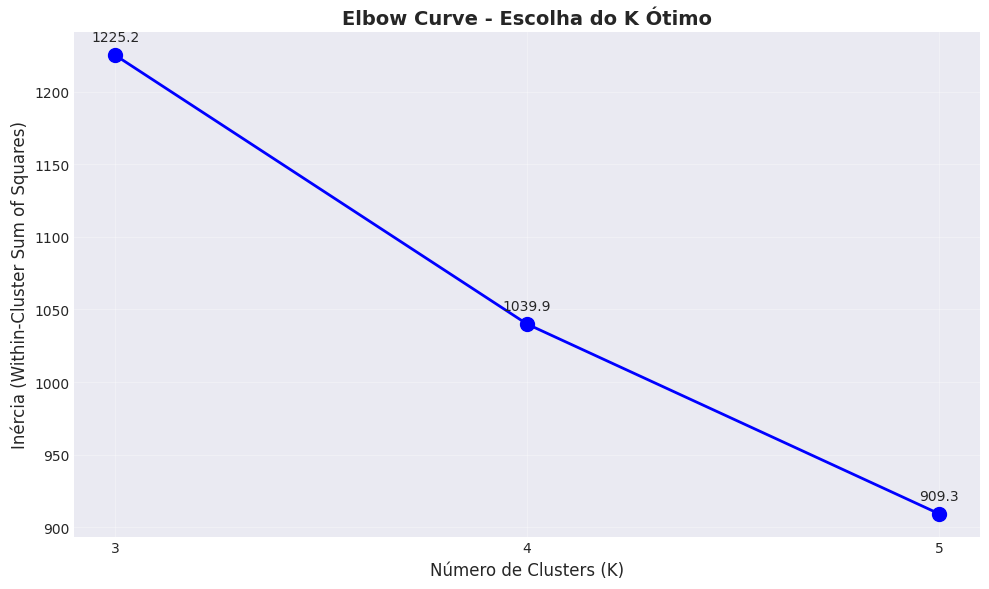


Elbow Curve salva em: outputs/elbow_curve.png


In [8]:
# Plotar Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_values, inertias, 'bo-', linewidth=2, markersize=10)
plt.xlabel('Número de Clusters (K)', fontsize=12)
plt.ylabel('Inércia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Curve - Escolha do K Ótimo', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_values)

# Adicionar valores no gráfico
for k, inertia in zip(K_values, inertias):
    plt.annotate(f'{inertia:.1f}', 
                xy=(k, inertia), 
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/elbow_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nElbow Curve salva em: outputs/elbow_curve.png")

## 6. Escolher Melhor K

In [9]:
# Calcular taxa de redução da inércia
print("Análise da redução de inércia:")
print("="*50)
for i in range(len(K_values)-1):
    k_atual = K_values[i]
    k_prox = K_values[i+1]
    reducao = inertias[i] - inertias[i+1]
    percentual = (reducao / inertias[i]) * 100
    print(f"K={k_atual} → K={k_prox}: {reducao:.2f} ({percentual:.1f}% de redução)")

# Escolher K (baseado no cotovelo visual e redução significativa)
best_k = 4  # Ajustar conforme análise visual
print(f"\n{'='*50}")
print(f"✓ K escolhido: {best_k}")
print(f"{'='*50}")

Análise da redução de inércia:
K=3 → K=4: 185.24 (15.1% de redução)
K=4 → K=5: 130.65 (12.6% de redução)

✓ K escolhido: 4


## 7. Analisar Clusters do Modelo Escolhido

In [10]:
# Obter labels do melhor modelo
best_model = models[best_k]
cluster_labels = best_model.labels_

# Adicionar labels ao dataframe original
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

# Estatísticas por cluster
print(f"\nDistribuição dos {best_k} clusters:")
print(df_clustered['cluster'].value_counts().sort_index())
print(f"\nPercentuais:")
print((df_clustered['cluster'].value_counts(normalize=True) * 100).sort_index().round(2))


Distribuição dos 4 clusters:
cluster
0     59
1    196
2    167
3     78
Name: count, dtype: int64

Percentuais:
cluster
0    11.8
1    39.2
2    33.4
3    15.6
Name: proportion, dtype: float64


In [11]:
# Perfil dos clusters (estatísticas das features originais)
cluster_profiles = df_clustered.groupby('cluster')[features.columns].mean()
print("\nPerfil médio dos clusters:")
cluster_profiles


Perfil médio dos clusters:


,media_renda,media_gasto,taxa_poupanca,pct_gastos_essenciais,std_gasto
cluster,,,,,
0,3692.620561,7297.556202,-0.886478,0.065104,3591.809935
1,3131.477503,3468.841613,-0.148150,0.050060,1411.290320
2,3154.587182,4900.489431,-0.576566,0.064806,1993.493171
3,7194.086258,5235.710114,0.254263,0.042461,2227.406566


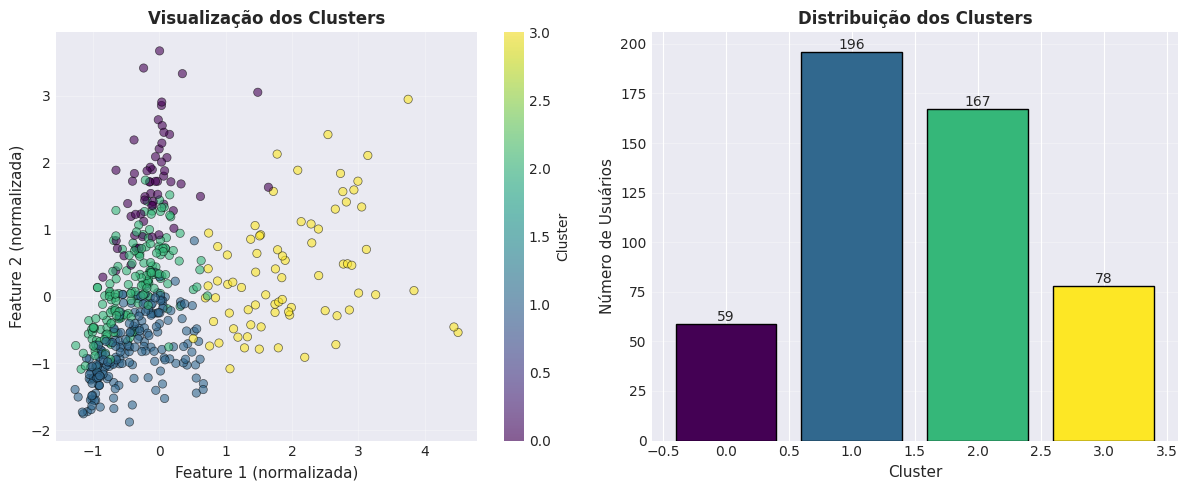


Visualização salva em: outputs/cluster_visualization.png


In [12]:
# Visualizar distribuição dos clusters (primeiras 2 features principais)
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(features_normalized[:, 0], 
                     features_normalized[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.xlabel('Feature 1 (normalizada)', fontsize=11)
plt.ylabel('Feature 2 (normalizada)', fontsize=11)
plt.title('Visualização dos Clusters', fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Tamanho dos clusters
plt.subplot(1, 2, 2)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors, edgecolor='black')
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Número de Usuários', fontsize=11)
plt.title('Distribuição dos Clusters', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualização salva em: outputs/cluster_visualization.png")

## 8. Salvar Modelos e Artefatos

In [13]:
# Criar diretório se não existir
import os
os.makedirs('../models', exist_ok=True)

# Salvar scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✓ Scaler salvo em: models/scaler.pkl")

# Salvar todos os modelos K-means
for k, model in models.items():
    filename = f'../models/kmeans_k{k}.pkl'
    joblib.dump(model, filename)
    print(f"✓ Modelo K={k} salvo em: models/kmeans_k{k}.pkl")

# Salvar modelo escolhido com nome especial
joblib.dump(best_model, '../models/kmeans_best.pkl')
print(f"\n✓ Modelo final (K={best_k}) salvo em: models/kmeans_best.pkl")

✓ Scaler salvo em: models/scaler.pkl
✓ Modelo K=3 salvo em: models/kmeans_k3.pkl
✓ Modelo K=4 salvo em: models/kmeans_k4.pkl
✓ Modelo K=5 salvo em: models/kmeans_k5.pkl

✓ Modelo final (K=4) salvo em: models/kmeans_best.pkl


In [14]:
# Salvar dataframe com clusters
df_clustered.to_csv('../data/processed/usuarios_clustered.csv', index=False)
print("✓ Dados com clusters salvos em: data/processed/usuarios_clustered.csv")

✓ Dados com clusters salvos em: data/processed/usuarios_clustered.csv


## 9. Resumo Final

In [15]:
print("="*60)
print("RESUMO DO CLUSTERING")
print("="*60)
print(f"\n✓ Modelos treinados: K={K_values}")
print(f"✓ Modelo escolhido: K={best_k}")
print(f"✓ Total de usuários: {len(df)}")
print(f"✓ Features utilizadas: {features.shape[1]}")
print(f"\nInércias:")
for k, inertia in zip(K_values, inertias):
    marker = "👉" if k == best_k else "  "
    print(f"{marker} K={k}: {inertia:.2f}")
print(f"\n✓ Artefatos salvos:")
print(f"  - models/scaler.pkl")
print(f"  - models/kmeans_k3.pkl, kmeans_k4.pkl, kmeans_k5.pkl")
print(f"  - models/kmeans_best.pkl (K={best_k})")
print(f"  - data/processed/usuarios_clustered.csv")
print(f"  - outputs/elbow_curve.png")
print(f"  - outputs/cluster_visualization.png")
print("\n" + "="*60)
print("CLUSTERING CONCLUÍDO! ✨")
print("="*60)

RESUMO DO CLUSTERING

✓ Modelos treinados: K=[3, 4, 5]
✓ Modelo escolhido: K=4
✓ Total de usuários: 500
✓ Features utilizadas: 5

Inércias:
   K=3: 1225.16
👉 K=4: 1039.92
   K=5: 909.28

✓ Artefatos salvos:
  - models/scaler.pkl
  - models/kmeans_k3.pkl, kmeans_k4.pkl, kmeans_k5.pkl
  - models/kmeans_best.pkl (K=4)
  - data/processed/usuarios_clustered.csv
  - outputs/elbow_curve.png
  - outputs/cluster_visualization.png

CLUSTERING CONCLUÍDO! ✨
